# Zero-shot prediction of BRCA1 variant effects with Evo 2
Deploy this tutorial on brev.dev: 
[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/launchable/deploy?launchableID=env-2txDJ6aPPhIYK1iLhsYFlWfPQRP)

*Note - this notebook is a reproduction of The Arc Institute’s same-titled notebook [here](https://github.com/ArcInstitute/evo2/blob/main/notebooks/brca1/brca1_zero_shot_vep.ipynb), using the BioNeMo 2 implementation of Evo2.*

The human *BRCA1* gene encodes for a protein that repairs damaged DNA ([Moynahan et al., 1999](https://www.cell.com/molecular-cell/fulltext/S1097-2765%2800%2980202-6)). Certain variants of this gene have been associated with an increased risk of breast and ovarian cancers ([Miki et al., 1994](https://www.science.org/doi/10.1126/science.7545954?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)). Using Evo 2, we can predict whether a particular single nucleotide variant (SNV) of the *BRCA1* gene is likely to be harmful to the protein's function, and thus potentially increase the risk of cancer for the patient with the genetic variant.

In [1]:
%%capture
!pip install biopython openpyxl

import glob
import gzip
import json
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from Bio import SeqIO
from pathlib import Path
from sklearn.metrics import roc_auc_score

from brca1_utils import (
    download_data,
    load_brca1_data, 
    load_genome_sequence,
    sample_data,
    generate_fasta_files
)


We start by loading a dataset from [Findlay et al. (2018)](https://www.nature.com/articles/s41586-018-0461-z), which contains experimentally measured function scores of 3,893 *BRCA1* SNVs. These function scores reflect the extent by which the genetic variant has disrupted the protein's function, with lower scores indicating greater disruption. In this dataset, the SNVs are classified into three categories based on their function scores: `LOF` (loss-of-function), `INT` (intermediate), and `FUNC` (functional). We start by reading in this dataset.

To keep the notebook streamlined, we've abstracted much of the preprocessing logic into accompanying scripts located in `brca1_utils`. The full notebook can be viewed [here](https://github.com/NVIDIA/bionemo-framework/blob/main/docs/docs/user-guide/examples/bionemo-evo2/evo2_zeroshot_brca.ipynb).

In [2]:
# Configuration parameters
DATA_DIR = 'brca1'
COMMIT_HASH = "3819474bee6c24938016614411f1fa025e542bbe"
SAMPLE_CONFIG = {
    'sample_frac': .05,
    'balanced': True,
    'disable': False,
    'random_state': 42
}

# 1. Download the necessary data files if not present
excel_path, genome_path = download_data(DATA_DIR, COMMIT_HASH)
seq_chr17 = load_genome_sequence(genome_path)

# 2. Load and preprocess BRCA1 data
brca1_df = load_brca1_data(excel_path)


We then group the `FUNC` and `INT` classes of SNVs together into a single category (`FUNC/INT`).



We build a function to parse the reference and variant sequences of a 8,192-bp window around the genomic position of each SNV, using the reference sequence of human chromosome 17 where *BRCA1* is located.



To make things run faster, we'll just look at a balanced sample of our data. If you want to run on the full dataset, set `disable_sample=True`

In [3]:
OUTPUT_DIR = "brca1_fasta_files"

brca1_df = sample_data(
    brca1_df, 
    sample_frac=SAMPLE_CONFIG['sample_frac'],
    balanced=SAMPLE_CONFIG['balanced'],
    disable=SAMPLE_CONFIG['disable'],
    random_state=SAMPLE_CONFIG['random_state']
)

brca1_df.head(5)


,chrom,pos,ref,alt,score,class
0,17,41199726,T,C,0.159762,FUNC/INT
1,17,41209074,T,A,-2.065569,LOF
2,17,41256913,A,C,-0.847753,FUNC/INT
3,17,41219631,T,A,-2.053739,LOF
4,17,41215965,G,A,-1.671525,LOF


Next, we'll write these to local `.fasta` files so we can use them for prediction below.

In [4]:
brca1_df = generate_fasta_files(
    brca1_df, 
    seq_chr17, 
    output_dir=OUTPUT_DIR
)

Total unique reference sequences: 79
Total unique variant sequences: 84



Then, we load Evo 2 1B model, loading the Evo 2 weights from hugging face.

*Note - for better performance, load the 7b model by setting `MODEL_SIZE="7b"` which also works well GPUs that do not support FP8.*



In [5]:
MODEL_SIZE = "1b"  # also try 7b if you have a GPU with more than 32GB of memory
# Define checkpoint path
checkpoint_path = Path(f"nemo2_evo2_{MODEL_SIZE}_8k")

# Check if the directory does not exist or is empty
if not checkpoint_path.exists() or not any(checkpoint_path.iterdir()):
    !evo2_convert_to_nemo2 --model-path hf://arcinstitute/savanna_evo2_1b_base --model-size {MODEL_SIZE} --output-dir nemo2_evo2_{MODEL_SIZE}_8k
else:
    print("Checkpoint directory is not empty. Skipping command.")


Checkpoint directory is not empty. Skipping command.


Next, we score the likelihoods of the reference and variant sequences of each SNV.


In [6]:
# Define output directories for prediction results
output_dir = Path("brca1_fasta_files")
output_dir.mkdir(parents=True, exist_ok=True)

# Save reference and variant sequences to FASTA
ref_fasta_path = output_dir / "brca1_reference_sequences.fasta"
var_fasta_path = output_dir / "brca1_variant_sequences.fasta"

predict_ref_dir = output_dir / "reference_predictions"
predict_var_dir = output_dir / "variant_predictions"
predict_ref_dir.mkdir(parents=True, exist_ok=True)
predict_var_dir.mkdir(parents=True, exist_ok=True)

# Check if FP8 is supported on the current GPU
def check_fp8_support():
    """
    Check if FP8 is supported on the current GPU.
    FP8 requires compute capability 8.9+ (Ada Lovelace/Hopper architecture or newer).
    """
    if not torch.cuda.is_available():
        return False, "CUDA not available"
    
    device_props = torch.cuda.get_device_properties(0)
    compute_capability = f"{device_props.major}.{device_props.minor}"
    device_name = device_props.name
    
    # FP8 is supported on compute capability 8.9+ (Ada Lovelace/Hopper architecture)
    is_supported = (device_props.major > 8) or (device_props.major == 8 and device_props.minor >= 9)
    
    return is_supported, f"Device: {device_name}, Compute Capability: {compute_capability}"

fp8_supported, gpu_info = check_fp8_support()
print(f"FP8 Support: {fp8_supported}")
print(gpu_info)

# Note: If FP8 is not supported, you may want to disable it in the model config
# The Evo2 config has 'use_fp8_input_projections: True' by default

fp8_option = "--fp8" if fp8_supported else ""

# Update predict commands to run on the full dataset
predict_ref_command = (
    f"predict_evo2 --fasta {ref_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_ref_dir} --model-size {MODEL_SIZE} --tensor-parallel-size 1 "
    f"--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs {fp8_option}"
)

predict_var_command = (
    f"predict_evo2 --fasta {var_fasta_path} --ckpt-dir {checkpoint_path} "
    f"--output-dir {predict_var_dir} --model-size {MODEL_SIZE} --tensor-parallel-size 1 "
    f"--pipeline-model-parallel-size 1 --context-parallel-size 1 --output-log-prob-seqs {fp8_option}"
)

FP8 Support: True
Device: NVIDIA RTX 5880 Ada Generation, Compute Capability: 8.9


In [13]:
%%capture
print(f"Running command: {predict_ref_command}")
!{predict_ref_command}

### Predict variant seqs (sample)

In [14]:
%%capture
print(f"Running command: {predict_var_command}")
!{predict_var_command}

We calculate the change in likelihoods for each variant relative to the likelihood of their respective wild-type sequence.



First, we load the prediction files and sequence id maps:

In [9]:
# Find and load prediction files
ref_pred_files = glob.glob(os.path.join(predict_ref_dir, "predictions__rank_*.pt"))
var_pred_files = glob.glob(os.path.join(predict_var_dir, "predictions__rank_*.pt"))

# Load sequence ID maps (maps sequence ID -> prediction index)
with open(os.path.join(predict_ref_dir, "seq_idx_map.json"), "r") as f:
    ref_seq_idx_map = json.load(f)
with open(os.path.join(predict_var_dir, "seq_idx_map.json"), "r") as f:
    var_seq_idx_map = json.load(f)

# Load predictions
ref_preds = torch.load(ref_pred_files[0])
var_preds = torch.load(var_pred_files[0])

Then, calculate the delta score:

In [10]:
# next, calculate change in likelihoods
ref_log_probs = []
var_log_probs = []
for _, row in brca1_df.iterrows():
    ref_name = row['ref_fasta_name']
    var_name = row['var_fasta_name']
    ref_log_probs.append(ref_preds['log_probs_seqs'][ref_seq_idx_map[ref_name]].item())
    var_log_probs.append(var_preds['log_probs_seqs'][var_seq_idx_map[var_name]].item())
brca1_df['ref_log_probs'] = ref_log_probs
brca1_df['var_log_probs'] = var_log_probs
# ideally probability of a broken variant is lower than a good one. So a bad var - good ref is negative.
brca1_df['evo2_delta_score'] = brca1_df['var_log_probs'] - brca1_df['ref_log_probs']
brca1_df.head()


,chrom,pos,ref,alt,score,class,ref_fasta_name,var_fasta_name,ref_log_probs,var_log_probs,evo2_delta_score
0,17,41199726,T,C,0.159762,FUNC/INT,BRCA1_ref_pos_41199726_T_class_FUNC/INT,BRCA1_var_pos_41199726_TtoC_class_FUNC/INT,-0.952961,-0.953517,-0.000556
1,17,41209074,T,A,-2.065569,LOF,BRCA1_ref_pos_41209074_T_class_LOF,BRCA1_var_pos_41209074_TtoA_class_LOF,-0.751052,-0.751063,-0.000011
2,17,41256913,A,C,-0.847753,FUNC/INT,BRCA1_ref_pos_41256913_A_class_FUNC/INT,BRCA1_var_pos_41256913_AtoC_class_FUNC/INT,-0.795621,-0.797192,-0.001571
3,17,41219631,T,A,-2.053739,LOF,BRCA1_ref_pos_41219631_T_class_LOF,BRCA1_var_pos_41219631_TtoA_class_LOF,-1.033116,-1.033407,-0.000291
4,17,41215965,G,A,-1.671525,LOF,BRCA1_ref_pos_41215965_G_class_LOF,BRCA1_var_pos_41215965_GtoA_class_LOF,-0.859719,-0.860393,-0.000674


This delta likelihood should be predictive of how disruptive the SNV is to the protein's function: the lower the delta, the more likely that the SNV is disruptive. We can show this by comparing the distributions of delta likelihoods for the two classes of SNVs (functional/intermediate vs loss-of-function).

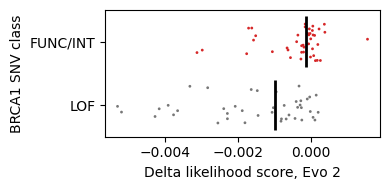

In [11]:
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1_df,
    x='evo2_delta_score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['C3', '#777777'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="evo2_delta_score",
            y="class",
            data=brca1_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()

We can also calculate the area under the receiver operating characteristic curve (AUROC) of this zero-shot prediction method. Note that the results are nearly random unless you are on one of the following configurations:
* `--fp8` on an fp8 enabled GPU with either the 1b or 7b models. The 40b likely works as well.
* the 7b model uniquely seems to work well without `--fp8` so if you are on an older device, the 7b model should produce
  robust results. Change the `MODEL_SIZE` earlier in this tutorial and rerun for good results in that case.



In [12]:
# Calculate AUROC of zero-shot predictions
#  class 1 is LOF which is the bad thing. That means we expect this to be more negative.
y_true = (brca1_df['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1_df['evo2_delta_score'])
print(f'Zero-shot prediction AUROC: {auroc:.2}')

Zero-shot prediction AUROC: 0.77
